This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

In [1]:
import socket
socket.gethostname()

'DESKTOP-ISTII7E'

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": 30002,
    "context_length": 256,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_60M = {
    "vocab_size": 30002,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": True
}

In [4]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_60M

In [5]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [6]:
trainer_config = {
    "dataset_scale": 50,
    "batch_size": 32 if "laptop" in hostname else 16,
    "epochs": 1,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 11 if "laptop" in hostname else 23,
    "max_lr": 1e-3
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [7]:
from components.gptmodel import GPTModel_v2
from torch.optim.lr_scheduler import OneCycleLR
from components.data import create_dataloader_v3
import lightning as L

class LitGPTModel(L.LightningModule):
    def __init__(self, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1
        x, y = batch
        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch

        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        with open(self.trainer_config["train_file_loc"], encoding="utf-8") as f:
            self.train_text = f.read()

            text_len = len(self.train_text)
            dataset_scale = self.trainer_config["dataset_scale"]
            self.train_text = self.train_text[:text_len // dataset_scale]

        with open(self.trainer_config["valid_file_loc"], encoding="utf-8") as f:
            self.valid_text = f.read()

            # ensure validation set is not too long
            train_len = len(self.train_text)
            self.valid_text = self.valid_text[:train_len // 10]

        self.model = GPTModel_v2(self.gpt_config)
        
    def _create_dataloader(self, text, train_loader):
        return create_dataloader_v3(
            text,
            batch_size=self.trainer_config["batch_size"],
            max_length=self.gpt_config["context_length"],
            stride=self.gpt_config["context_length"],
            drop_last=train_loader,
            shuffle=train_loader,
            num_workers=self.trainer_config["num_workers"]
        )

    def train_dataloader(self):
        # consider setting self.train_text = None if memory consumption is an issue
        train_loader = self._create_dataloader(
            self.train_text,
            train_loader=True
        )
        return train_loader

    def val_dataloader(self):
        return self._create_dataloader(
            self.valid_text,
            train_loader=False
        )


In [8]:
litmodel = LitGPTModel(
    trainer_config,
    GPT_CONFIG
)

In [9]:
%%time

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"]
)
trainer.fit(model=litmodel)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-01 14:06:08.451582: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 14:06:08.464668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743541568.475551    4359 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743541568.478742    4359 cuda_blas.cc:1407] Unable to regis

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 3396/3396 [03:04<00:00, 18.36it/s, v_num=42, accuracy_step=0.777, loss_step=1.060]
Validation: |                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 343/343 [00:07<00:00, 47.79it/s]
Epoch 0: 100%|█| 3396/3396 [03:12<00:00, 17.65it/s, v_num=42, accuracy_step=0.777, loss_step=1.060, val_accuracy_step=0.692, val_loss_step=1.490, val_accuracy_epoch=0.745, val_loss_epoch=

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|█| 3396/3396 [03:13<00:00, 17.58it/s, v_num=42, accuracy_step=0.777, loss_step=1.060, val_accuracy_step=0.692, val_loss_step=1.490, val_accuracy_epoch=0.745, val_loss_epoch=
CPU times: user 3min 9s, sys: 11.3 s, total: 3min 20s
Wall time: 3min 20s


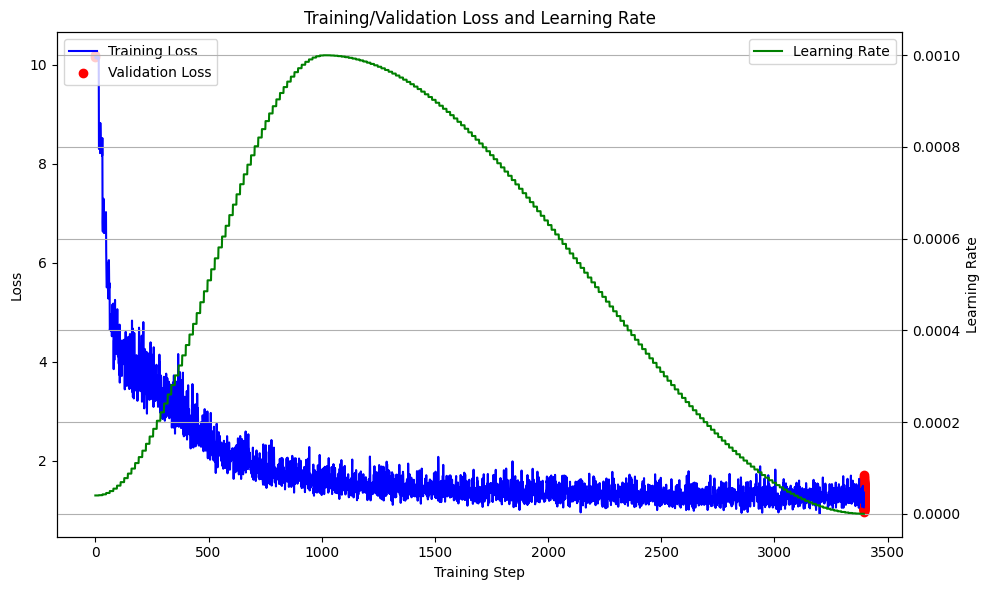

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

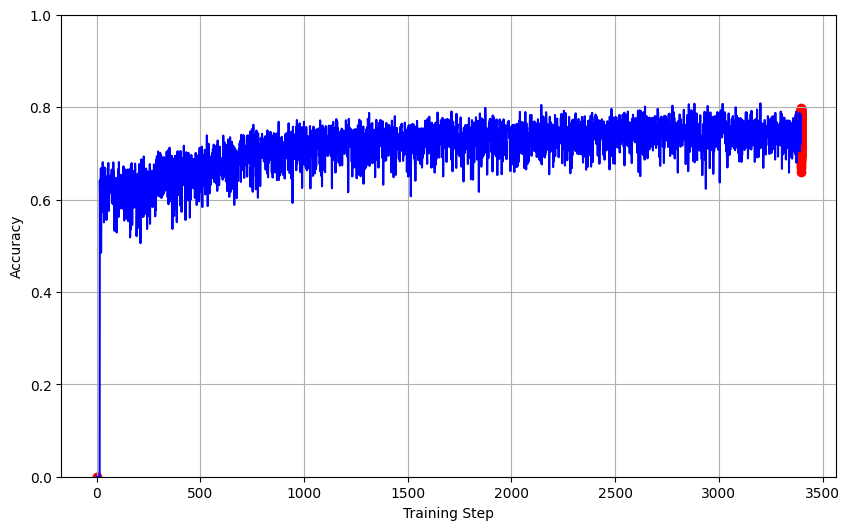

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [12]:
from tokenizers import Tokenizer

In [13]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [14]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [15]:
from components.generatetext import generate_text

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

GPTModel_v2(
  (tok_emb): Embedding(30002, 512)
  (pos_emb): Embedding(512, 512)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock_v2(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=512, out_features=512, bias=False)
        (W_key): Linear(in_features=512, out_features=512, bias=False)
        (W_value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock_v2(
     

In [17]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is not happy to the end of fun. He learned to help me. He learned that you." They are happy and happy. The end. Tom learned to the story about it was not want their friends and Tom. From that they all played with the end, Tom and they both happy. From that day, Tom learned to the story is that the best friends, and they both laughed. They learned that they were very happy again, and Tom learned a good. They all their mom, and they all day long. The moral of their mom said, and they both laughed and Tom learned that they both laughed and the story. The moral anymore, and they both learned to be careful. They both learned a good at the end, but the e

In [18]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is that it." They both learned that they are happy and they are you. Tom. The moral. The moral anymore. Tom learned to help others. The moral of the end. The end of their friends, and Tom and Tom learned to the best friend. They both learned to be friends and the end, they both laughed. The end. They learned that day, and Tom. The moral of their mom said, and they were happy and the story is happy and the story is happy again and they both happy. They learned to the end. The moral of their friends again. The moral of fun together every day long time.
CPU times: user 388 ms, sys: 8.88 ms, total: 396 ms
Wall time: 418 ms


In [19]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is not want the story is that day, but they were happy and the story is that you. The dog.
CPU times: user 72.2 ms, sys: 9.89 ms, total: 82.1 ms
Wall time: 86 ms


In [20]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is good friends and Tom. From then you." Tom, but they both happy that the story about their mom. From that they both laughed and the story is not happy that day on, Tom and they are you are you." They both happy and Tom and Tom and Tom and Tom and they both happy again, and Tom learned that day. The moral of fun. They both learned that they both learned to help others. They are not happy. Tom and the best. And that day. And that day.
CPU times: user 337 ms, sys: 28.8 ms, total: 366 ms
Wall time: 385 ms
